# Métodos kernel para regresión

### 1. Escribe una función que descargue automáticamente el fichero de datos con medidas mensuales de la URL ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt y que lo convierta a un formato numérico (dataframe, numpy arrays, etc.).

In [3]:
# Download the dataset (if the server responds)
import urllib.request

url = 'ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt'
my_file = urllib.request.urlretrieve(url, 'file.txt')

### 2. Obten las variables months y avg_ppmvs.

In [4]:
# Read the dataset
import pandas as pd
import numpy as np

# Load the dataset as a pandas dataframe
df = pd.read_csv("file.txt", 
               sep = "   ",
               header = 71)

# Name the columns so that it is easy to drop the ones I do not want to use
df.columns = ['year', 'months', '---', '---', 'avg_ppmvs', '---', 'interpolated',  '---', 'trend', 'days', '---', '---', '---', '---']

# Drop the unused columns
df = df.drop('---', axis = 1)

# Take a look at the dataset I selected
df.head(5)

/home/nicolo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,year,months,avg_ppmvs,interpolated,trend,days
0,1958,3.0,315.71,315.71,314.62,-1.0
1,1958,4.0,317.45,317.45,315.29,-1.0
2,1958,5.0,317.50,317.50,314.71,-1.0
3,1958,6.0,-99.99,317.10,314.85,-1.0
4,1958,7.0,315.86,315.86,314.98,-1.0


### 3. Comprueba si los datos coinciden con los datos usados en la práctica (devueltos por load_mauna_loa_atmospheric_co2()) para las fechas en que existen datos en ambos conjuntos.

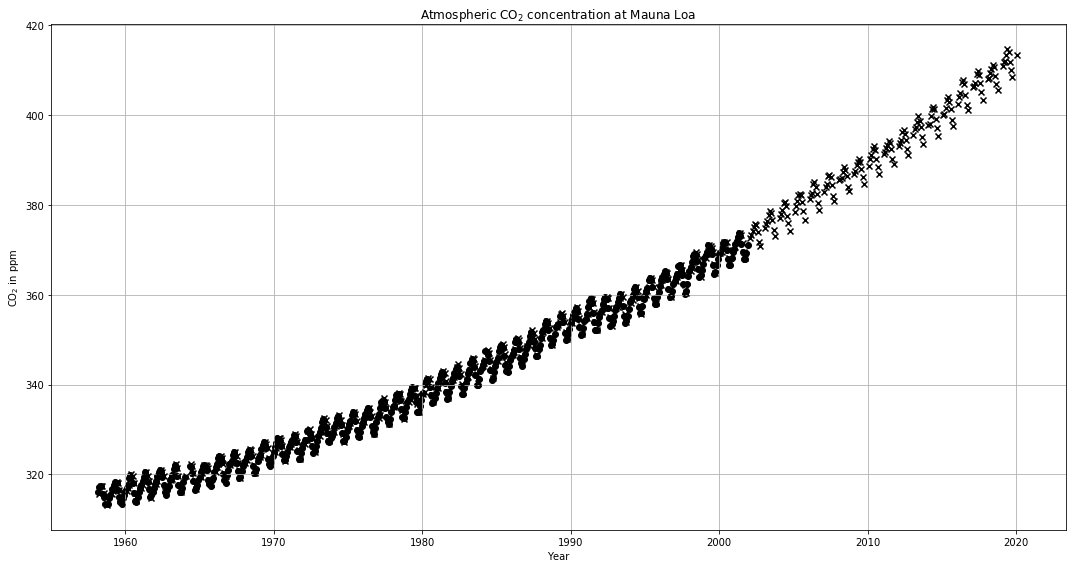

In [5]:
# Prepare the 'load_mauna_loa_atmospheric_co2()' function
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

# Original series
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187, cache=False)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

X, y = load_mauna_loa_atmospheric_co2()

# Illustration
fig = plt.figure(figsize=(15,8))
plt.scatter(X, y, c='k', zorder = 1)
plt.grid(True)
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()


# Updated series (till today)

# Remove invalid values
df2 = df[df['avg_ppmvs'] > -9.99]

# The series starts on March 1958 (1/4 of year after 1958)
X2 = np.asarray(df2.index / 12 + 1958 + 0.25).reshape(-1, 1)
y2 = df2.avg_ppmvs

plt.scatter(X2, y2, c='k', marker = 'x', zorder = 2)
plt.grid(True)

### 4. Busca los mejores hiperparámetros del GP para predecir la serie temporal del CO2 usando datos hasta la fecha más reciente. Compara estos hiperparámetros con los que se encontraron al usar datos hasta diciembre de 2001 (los datos usados en la práctica).

In [6]:
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel, ExpSineSquared


from time import time

# Kernel with generic parameters
k1 = C(50, (1e1, 1e+3)) * RBF(50,(1e0,1e5))  # long term smooth rising trend
k2 = C(5, (1e1, 1e+2)) * RBF(100,(1e0,1e5)) \
    * ExpSineSquared(length_scale=1.0, length_scale_bounds=(1e-1,1e1),
                     periodicity=1.0, periodicity_bounds="fixed")  # seasonal component
k3 = C(0.5, (1e-2, 1e1)) * RationalQuadratic(length_scale=1.0, length_scale_bounds=(1e-2,1e3),
                                alpha=1.0, alpha_bounds=(1e-1,1e3)) # medium term irregularities
k4 = C(0.1, (1e-3, 1e+1)) * RBF(0.1,(1e-2,1e2)) \
    + WhiteKernel(noise_level=0.1**2,noise_level_bounds=(1e-4, 1e0)) # noise terms
kernel = k1 + k2 + k3 + k4

# Fit the Gaussian Process regressor, and optimize the hyperparameters
gp = GaussianProcessRegressor(kernel=kernel, alpha=0,
                              normalize_y=True, n_restarts_optimizer=1)
t0 = time()

In [7]:
gp.fit(X2, y2)

GaussianProcessRegressor(alpha=0, copy_X_train=True,
                         kernel=7.07**2 * RBF(length_scale=50) + 2.24**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.707**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.316**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=1, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=None)

#### Paramters obtained in the current exercise

In [78]:
print("Elapsed time: %0.3fs"%(time() - t0))

print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

Elapsed time: 16.010s

Learned kernel: 31.6**2 * RBF(length_scale=28) + 3.3**2 * RBF(length_scale=141) * ExpSineSquared(length_scale=1.64, periodicity=1) + 0.634**2 * RationalQuadratic(alpha=0.533, length_scale=1.1) + 0.206**2 * RBF(length_scale=0.116) + WhiteKernel(noise_level=0.0477)
Log-marginal-likelihood: -209.986


    31.6**2 * RBF(length_scale=28) 
    + 3.3**2 * RBF(length_scale=141) * ExpSineSquared(length_scale=1.64, periodicity=1) 
    + 0.634**2 * RationalQuadratic(alpha=0.533, length_scale=1.1) 
    + 0.206**2 * RBF(length_scale=0.116) 
    + WhiteKernel(noise_level=0.0477)

    Log-marginal-likelihood: -209.986

#### Parameters used in the original paper

In [9]:
from sklearn.gaussian_process.kernels import RationalQuadratic

# Kernel with parameters given in GPML book
k1 = 66**2 * RBF(67)  # long term smooth rising trend
k2 = 2.4**2 * RBF(90) * ExpSineSquared(length_scale=1.3, periodicity=1.0) # seasonal component
k3 = 0.66**2 * RationalQuadratic(length_scale=1.2, alpha=0.78) # medium term irregularity
k4 = 0.18**2 * RBF(0.134) + WhiteKernel(0.19**2) # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(X2, y2)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

GPML kernel: 66**2 * RBF(length_scale=67) + 2.4**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1.3, periodicity=1) + 0.66**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.0361)
Log-marginal-likelihood: -226.868


    66**2 * RBF(length_scale=67) 
    + 2.4**2 * RBF(length_scale=90) * ExpSineSquared(length_scale=1.3, periodicity=1) 
    + 0.66**2 * RationalQuadratic(alpha=0.78, length_scale=1.2) 
    + 0.18**2 * RBF(length_scale=0.134) 
    + WhiteKernel(noise_level=0.0361)

    Log-marginal-likelihood: -226.868

#### Parameters extracted in the exercise in class

In [13]:
from sklearn.gaussian_process.kernels import RationalQuadratic

# Kernel with parameters given in GPML book
k1 = 31.6**2 * RBF(45.6)  # long term smooth rising trend
k2 = 3.16**2 * RBF(97.1) * ExpSineSquared(length_scale=1.58, periodicity=1.0) # seasonal component
k3 = 0.536**2 * RationalQuadratic(length_scale=0.967, alpha=3.06) # medium term irregularity
k4 = 0.189**2 * RBF(0.122) + WhiteKernel(0.0367) # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer=None, normalize_y=True)
gp.fit(X2, y2)

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

GPML kernel: 31.6**2 * RBF(length_scale=45.6) + 3.16**2 * RBF(length_scale=97.1) * ExpSineSquared(length_scale=1.58, periodicity=1) + 0.536**2 * RationalQuadratic(alpha=3.06, length_scale=0.967) + 0.189**2 * RBF(length_scale=0.122) + WhiteKernel(noise_level=0.0367)
Log-marginal-likelihood: -229.645


    31.6**2 * RBF(length_scale=45.6) 
    + 3.16**2 * RBF(length_scale=97.1) * ExpSineSquared(length_scale=1.58, periodicity=1) 
    + 0.536**2 * RationalQuadratic(alpha=3.06, length_scale=0.967) 
    + 0.189**2 * RBF(length_scale=0.122) 
    + WhiteKernel(noise_level=0.0367)

    Log-marginal-likelihood: -229.645

### Interpretation of the results

As expected, the largest value for the Log-marginal-likelihood, is given by the kernel specifically tuned for the most updated data.

The main difference in the parameters can be observed in the first term, (RBF alone), which fits the long term rising trend. This can be interpreted as a change in the trend of the rising in Co2 concentration in the atmosphere.

This hypotesis seems to be strengthen by the fact that the other kernel that shows different parameters is the RationalQuadratic one, responsible of explaining the medium-term irregularities, while the noise term and the seasonal components appear to be just fluctuating around the same value, with small differences given more by the oscillation of the fine tuning than by a real change in the fitted data.

### 5. Haz una figura que muestre la serie temporal completa y una predicción de los próximos 20 años, incluso bandas de confianza.

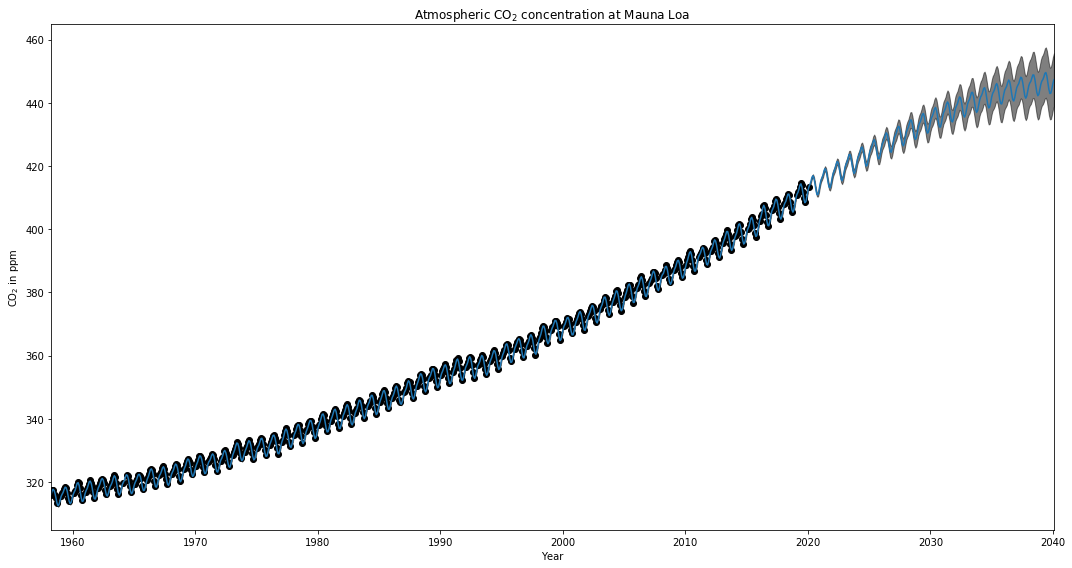

In [79]:
# Prepare the X_ for the next 20 years
X_ = np.linspace(X2.min(), X2.max() + 20, 1000)[:, np.newaxis]

# Predict on the new X_
y_pred, y_std = gp.predict(X_, return_std=True)

# plot the prediction
fig = plt.figure(figsize=(15,8))
plt.scatter(X2, y2, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()